In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 10]

# orion galactic coordinate grid

In [2]:
LAT = (160, 220)
LON = (-70, -10)
delta_spacing = 2 # deg

In [3]:
# custom latitude spacing for orion, see lab 4 spec
delta_lat_conv = lambda b: delta_spacing / np.cos(np.deg2rad(b))
glons = range(LON[0], LON[1], delta_spacing)

pointings = []
for b in glons:
    lats = np.arange(LAT[0], LAT[1], delta_lat_conv(b))
    b_col = [[L, b] for L in lats]
    pointings += b_col
    
pointings = np.array(pointings)
print('Number of pointings:', pointings.shape)

Number of pointings: (664, 2)


In [7]:
np.save('pointings', pointings)

In [33]:
# estimate center
np.mean(pointings, axis=0)

array([189.32709197, -36.54216867])

# visualize

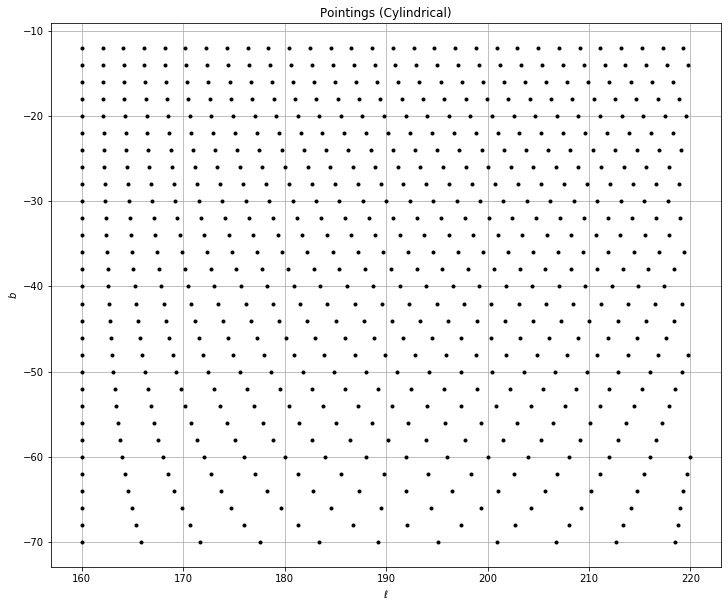

In [30]:
# plt.figure(figsize=(14, 1))
plt.plot(pointings[:,0], pointings[:,1], 'k.')
plt.grid()
plt.xlabel('$\ell$')
# plt.xlim(-183,183)
# plt.ylim(81,93)
plt.ylabel('$b$')
_ = plt.title('Pointings (Cylindrical)')

In [7]:
# installing cartopy may cause problems
import cartopy.crs as ccrs

In [8]:
import matplotlib.path as mpath

def add_circle_boundary(ax):
    '''Compute a circle in axes coordinates, which we can use as a boundary
    for the map. We can pan/zoom as much as we like - the boundary will be
    permanently circular.'''
    theta = np.linspace(0, 2*np.pi, 100)
    #center, radius = [0.5, 0.5], 0.5
    center, radius = [0.5, 0.5], 1
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

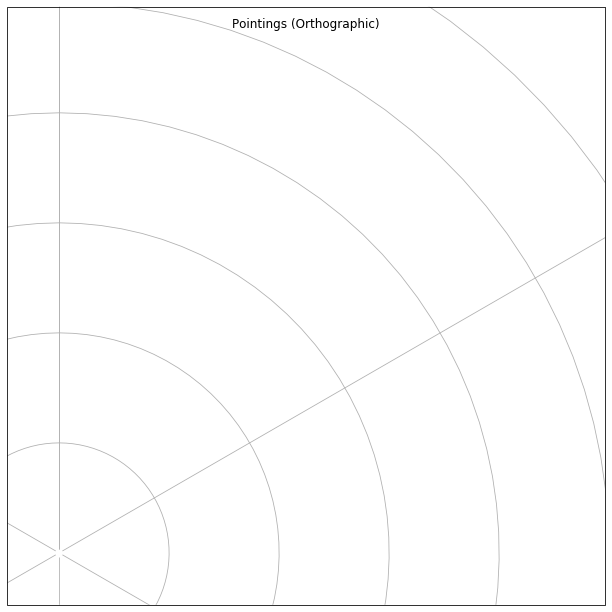

In [28]:
# plt.figure(figsize=(6,6))

proj = ccrs.Orthographic(central_latitude=90)
geo = ccrs.Geodetic()
prj_pnts = proj.transform_points(geo, pointings[:,0], pointings[:,1])
ax = plt.axes(projection=proj)
ax.plot(prj_pnts[:,0], prj_pnts[:,1], 'k.')
add_circle_boundary(ax)
ax.gridlines()
_ = plt.title('Pointings (Orthographic)')

In the worst case, the entire top row of pointings mapped to one single point at the pole. The other rows are only marignally better: the longitudes may be spaced every $3^\circ$, but the actual separation between pointings on
the sky is much less than that.

We've spent 360 pointings covering about $\pi (6^\circ)^2\approx110$ square degrees on the sky (roughly 3 pointings per square degree), but our beam had an angular area of about 28 square degrees. We could have Nyquist sampled this region with about $110 / (28 / 4)\approx16$ pointings (the factor of 4 accounts for Nyquist sampling along two axes).

A better way to go about sampling this area is to define a more uniform grid away from the pole of this coordinate system, and then to shift it up here.

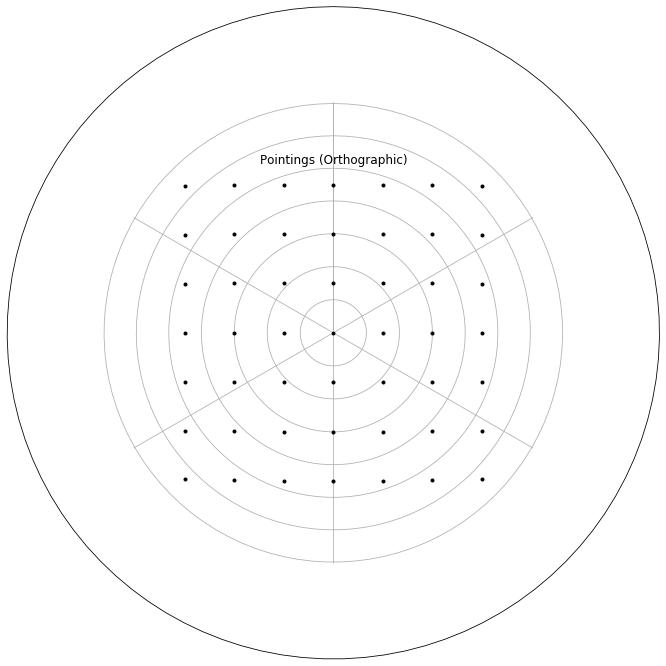

In [29]:
# define a center point along the x axis (orthogonal to the z pole)
theta0, phi0 = 90, 0 # deg

# build some uniform spacings around this center
ang_sep = 3 # deg
thetas = np.deg2rad(theta0 + ang_sep * np.arange(-3, 4))
phis = np.deg2rad(ang_sep * np.arange(-3, 4))

# convert angles to 3-vectors for easier rotation
x = np.outer(np.sin(thetas), np.cos(phis)).flatten()
y = np.outer(np.sin(thetas), np.sin(phis)).flatten()
z = np.outer(np.cos(thetas), np.ones_like(phis)).flatten()

# rotate the x coordinate up to the z axis
m = np.array([[ 0, 1, 0],
              [ 0, 0,-1],
              [ 1, 0, 0]])
x, y, z = np.dot(m, np.array([x, y, z]))

# turn 3-vectors back into angles
thetas = np.arctan2(np.sqrt(x**2 + y**2), z)
phis = np.arctan2(y, x)
lat = 90 - np.rad2deg(thetas)
lon = np.rad2deg(phis)

pointings1 = np.array([(L, b) for L, b in zip(lon, lat)])

plt.figure(figsize=(6,6))

proj = ccrs.Orthographic(central_latitude=90)
geo = ccrs.Geodetic()
prj_pnts = proj.transform_points(geo, pointings1[:,0], pointings1[:,1])
ax = plt.axes(projection=proj)
ax.plot(prj_pnts[:,0], prj_pnts[:,1], 'k.')
add_circle_boundary(ax)
ax.gridlines()
_ = plt.title('Pointings (Orthographic)')